# MCGrad Core Algorithm Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookincubator/MCGrad/blob/main/tutorials/01_mcgrad_core.ipynb)

This tutorial provides a comprehensive introduction to **MCGrad** (Multicalibration Gradient Boosting),
a powerful algorithm for calibrating machine learning predictions across arbitrary population segments.

You can find more information about MCGrad at [mcgrad.dev](https://mcgrad.dev).

In this tutorial notebook we demonstrate MCGrad using data from the American Community Survey. We train a logistic regression *base model* to predict a respondent's binary employment status. You'll see how a the base model can suffer from multicalibration error out of the box, and how MCGrad can fix it.

## Outline

1. **Setup** - Download the ACS employment dataset and train a logistic regression model
2. **Assessing Model Performance, Calibration and Multicalibration** - Introduce multicalibration, how to measure it, and demonstrate that global calibration methods can fail to address it
3. **MCGrad Basics** - Fit MCGrad to fix multicalibration error
4. **Model Evaluation** - Use MCGrad's plotting and evaluation tools to compare base model, global calibration, and MCGrad
5. **Advanced Features** - Hyperparameter tuning, MCE metric details, and serialization for production use

## 1. Setup

* MCGrad must be installed. See the [installation guide](https://facebookincubator.github.io/MCGrad/) for instructions.

In [2]:
# Setup for Colab
import sys
if 'google.colab' in sys.modules:
    # Install MCGrad
    !pip install -q "MCGrad[tutorials] @ git+https://github.com/facebookincubator/MCGrad.git"
    # Download helper module
    !wget -q https://raw.githubusercontent.com/facebookincubator/MCGrad/tutorial_notebooks/tutorials/helpers.py

In [4]:
import numpy as np
import pandas as pd
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split

from mcgrad import metrics, methods, plotting

* To keep this tutorial compact, helper functions are located in `helpers.py` in this directory.

In [10]:
from helpers import (
    BINARY_COLUMNS,
    CATEGORICAL_COLUMNS,
    LABEL_COLUMN,
    NUMERICAL_COLUMNS,
    combine_segment_calibration_plots,
    configure_logging,
    create_logistic_pipeline,
    format_calibration_metrics_table,
    load_acs_employment_data,
    setup_plotting,
)

In [5]:
# Notebook setup
setup_plotting()
configure_logging()

### 1.1 Dataset and ML task

We use a sample of the American Community Survey (ACS) dataset containing information on respondents' *employment status* (binary: employed/unemployed) along with sociodemographic features:

| Column Name | Description |
|-------------|-------------|
| AGEP | Age of the individual (in years) |
| SCHL | Educational attainment (ordinal code for highest level of schooling) |
| MAR | Marital status |
| RELP | Relationship to the household reference person |
| DIS | Disability status indicator |
| ESP | English-speaking ability (limited English proficiency indicator) |
| CIT | Citizenship status |
| MIG | Mobility status (whether the person lived in the same house 1 year ago) |
| MIL | Military service status |
| ANC | Ancestry (self-reported primary ancestry) |
| NATIVITY | Nativity (U.S.-born vs foreign-born) |
| DEAR | Hearing difficulty indicator |
| DEYE | Vision difficulty indicator |
| DREM | Cognitive difficulty indicator |
| SEX | Sex |
| RAC1P | Race (single-race category) |
| **employment_label** | Employment status (binary target variable) |

In [6]:
employment_df = load_acs_employment_data(states=["TX", "MI", "PA"])
employment_df.head()

Dataset has 496585 samples


,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,employment_label
0,21.0,16.0,5,17,2,0,1,1,4,1,1,2,2,2,2,2,True
1,19.0,16.0,5,17,2,0,1,1,4,1,1,2,2,2,2,1,False
2,24.0,12.0,5,16,1,0,1,1,4,1,1,2,2,1,1,2,False
3,20.0,16.0,5,17,2,0,1,1,3,1,1,2,2,2,2,1,True
4,31.0,17.0,5,17,2,0,1,3,4,4,1,2,2,2,1,1,True


First we split the data into training and test portions and separate features and labels

In [8]:
train_df, test_df = train_test_split(
    employment_df, test_size=0.30, random_state=42, stratify=employment_df[LABEL_COLUMN]
)

X_train = train_df.drop(columns=[LABEL_COLUMN])
y_train = train_df[LABEL_COLUMN].astype(int).to_numpy()

X_test = test_df.drop(columns=[LABEL_COLUMN])
y_test = test_df[LABEL_COLUMN].astype(int).to_numpy()

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 347609, Test: 148976


### 1.2 Train the base model

We train a logistic regression model using all features to predict employment status. The pipeline (defined in `helpers.py`) applies standard scaling to numerical features and one-hot encoding to categorical features.

In [9]:
logistic_pipeline = create_logistic_pipeline()
logistic_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical', ...), ('binary', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differ

## 2. Assessing Model Performance, Calibration and Multicalibration

A model is *calibrated* if its predicted probabilities match observed frequencies—e.g., among all predictions of score 0.7, roughly 70% should be positive. We first evaluate the base model's predictive performance and calibration on the test set.

In [11]:
BASE_MODEL_PREDICTION_COLUMN = 'base_model_prediction'
test_df[BASE_MODEL_PREDICTION_COLUMN] = logistic_pipeline.predict_proba(test_df.drop(columns=[LABEL_COLUMN]))[:,1]
# We also produce a prediction for the training df so we can use the scores to train the calibration algorithm later
train_df[BASE_MODEL_PREDICTION_COLUMN] = logistic_pipeline.predict_proba(train_df.drop(columns=[LABEL_COLUMN]))[:,1]

Let's first examine the model's predictive performance. We compute the area under the precision-recall curve (PRAUC), the area under the ROC curve (ROCAUC), and log-loss.

### 2.1 Discriminative Performance

In [12]:
evaluation_metrics = {
    "PRAUC": skmetrics.average_precision_score,
    "ROCAUC": skmetrics.roc_auc_score,
    "log-loss": skmetrics.log_loss,
}

perf_metrics = {
    metric_name: metric_func(
        test_df[LABEL_COLUMN].values,
        test_df[BASE_MODEL_PREDICTION_COLUMN].values,
    )
    for metric_name, metric_func in evaluation_metrics.items()
}
pd.DataFrame.from_dict(perf_metrics, orient='index').rename(columns={0: 'base_model'}).round(3)

,base_model
PRAUC,0.824
ROCAUC,0.880
log-loss,0.421


The base model shows strong discriminative performance (ROCAUC ≈ 0.88, PRAUC ≈ 0.82). Now let's assess calibration quality using `plot_global_calibration_curve`:

### 2.2 Global Calibration

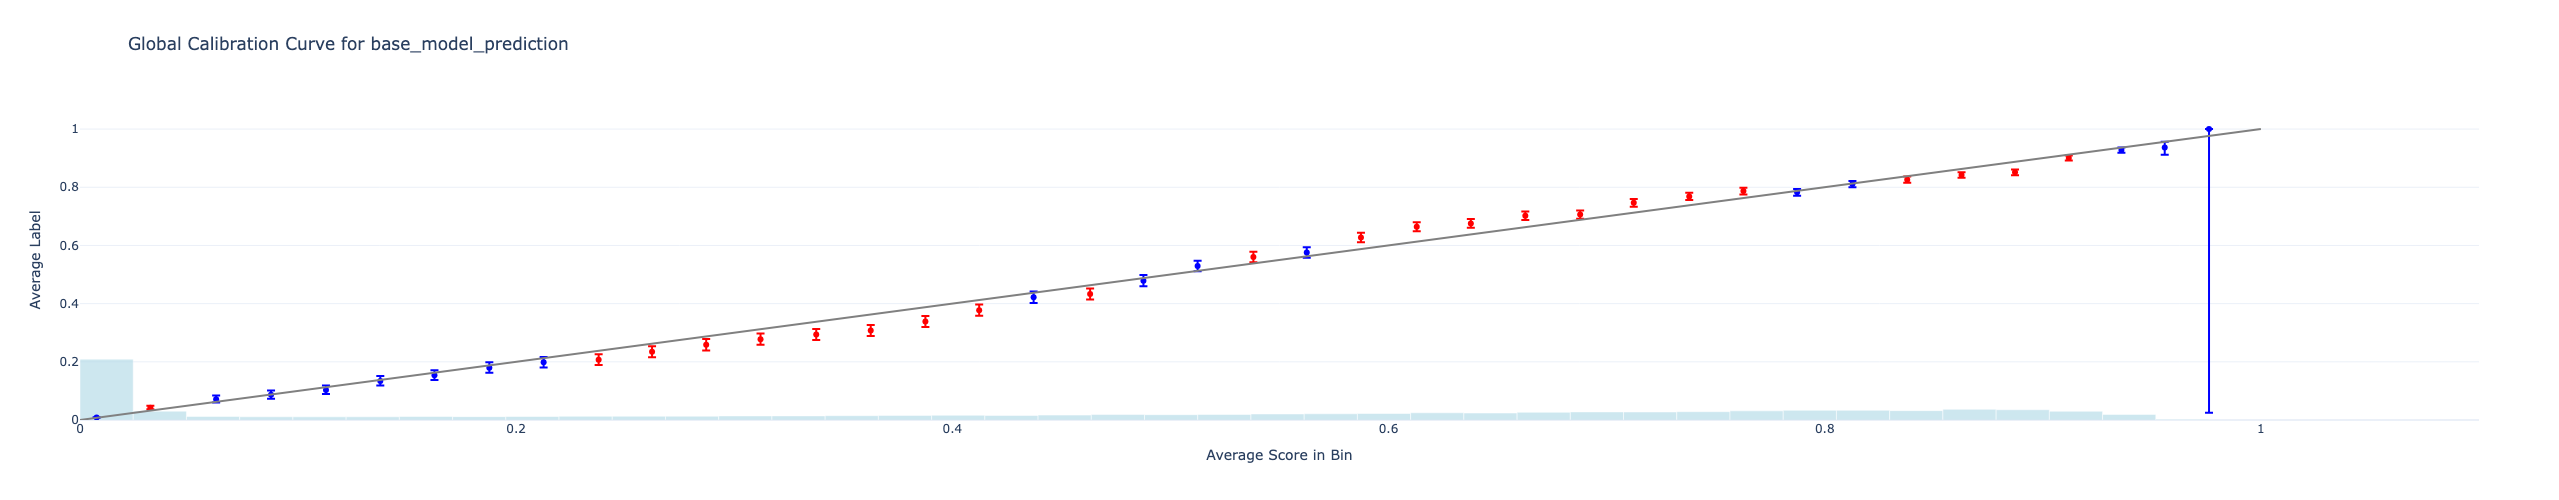

In [13]:
plotting.plot_global_calibration_curve(
    data=test_df,
    score_col=BASE_MODEL_PREDICTION_COLUMN,
    label_col=LABEL_COLUMN,
    num_bins=40,
).update_layout(title=f"Global Calibration Curve for {BASE_MODEL_PREDICTION_COLUMN}", width=700, height=500)

The light blue histogram shows the distribution of predicted scores. The calibration curve is computed by binning predictions and calculating the proportion of positive labels in each bin. A perfectly calibrated model produces points along the 45° diagonal. The 95% confidence intervals help distinguish statistically significant miscalibration from noise.

Our logistic regression model shows decent global calibration, but some score ranges are significantly miscalibrated—the model systematically over- or under-predicts employment probability in certain regions.

To quantify this, we use the **Expected Cumulative Calibration Error (ECCE)**, which doesn't rely on bin count and has well-understood statistical properties. See the [methodology documentation](https://facebookincubator.github.io/MCGrad/docs/measuring-multicalibration) for details.

The ECCE distribution under perfect calibration is known analytically, allowing us to compute a "sigma scale"—the number of standard deviations the observed error lies from zero. Values above 5σ rougly indicate significant miscalibration. We access these metrics using the functions `ecce` and `ecce_sigma` in the `metrics` submodule:

In [98]:
def compute_ecce_with_sigma(labels, predictions):
    return metrics.ecce(labels, predictions), metrics.ecce_sigma(labels, predictions)

In [103]:
# TODO: Update after MCE refactor has landed
ecce_base_model, ecce_sigma_base_model = compute_ecce_with_sigma(test_df[LABEL_COLUMN].values, test_df[BASE_MODEL_PREDICTION_COLUMN].values)

print(f"Global miscalibration of the base model:\nECCE: {ecce_base_model:.4f}, ({ecce_sigma_base_model:.2f} sigmas)")

Global miscalibration of the base model:
ECCE: 0.0085, (8.74 sigmas)


The ECCE is 0.0085 on the absolute (probability) scale which corresponds to 8.7 sigmas. That is, there is a lot of statistical evidence of global miscalibration. The model's calibration can be improved!

We can fix global miscalibration by applying an off-the-shelve calibration method such as Isotonic Regression. `mcgrad` provides several such methods in the `methods` module. Let's fit Isotonic Regression and see what it does to global calibration.

In [104]:
isotonic_regression = methods.IsotonicRegression().fit(
    train_df,
    BASE_MODEL_PREDICTION_COLUMN,
    LABEL_COLUMN,
)

In [105]:
IR_SCORE_COL = 'score_isotonic_regression'
test_df[IR_SCORE_COL] = isotonic_regression.predict(
    test_df,
    BASE_MODEL_PREDICTION_COLUMN,
)

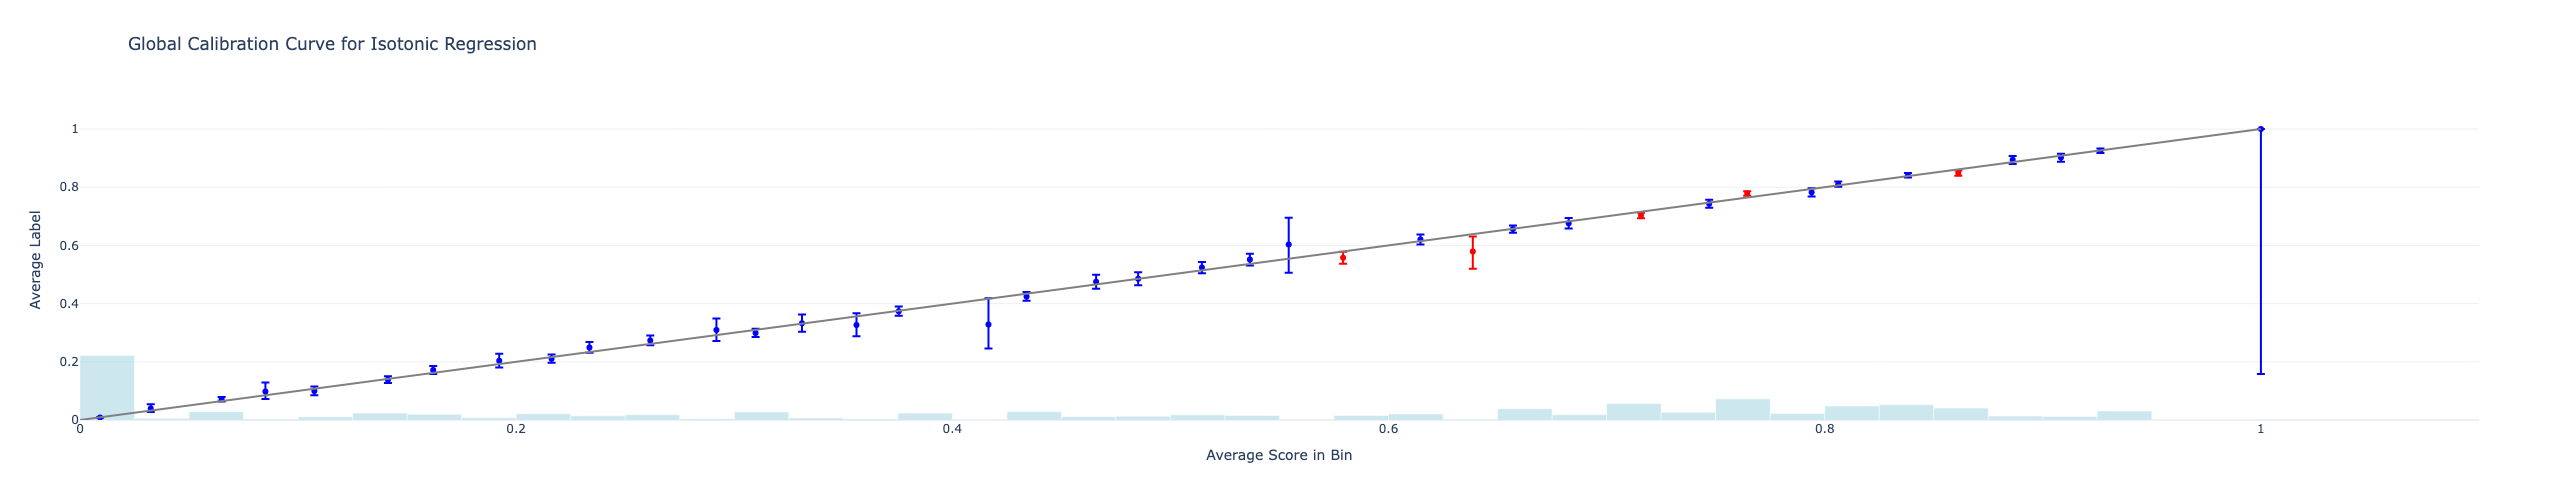

In [106]:
plotting.plot_global_calibration_curve(
    data=test_df,
    score_col=IR_SCORE_COL,
    label_col=LABEL_COLUMN,
    num_bins=40,
).update_layout(title=f"Global Calibration Curve for Isotonic Regression", width=700, height=500)

It looks like the isotonic regression model fixed the global miscalibration in the base model successfully. There are only a few buckets that deviate significantly from the diagonal of perfect calibration (for 40 bins we expect 2 significant deviations at 95% confidence). Let's additionally check the ECCE metric:

In [118]:
# TODO: Update after MCE refactor has landed
ecce_ir, ecce_sigma_ir = compute_ecce_with_sigma(test_df[LABEL_COLUMN].values, test_df[IR_SCORE_COL].values)

print(f"Global miscalibration of the base model:\nECCE: {ecce_ir:.6f}, ({ecce_sigma_ir:.2f} sigmas)")

Global miscalibration of the base model:
ECCE: 0.001674, (1.74 sigmas)


There's little evidence of global miscalibration remaining. The calibration error is greatly reduced, and the sigma scale suggests further improvement is unlikely with this dataset size. So we're done, right?

### 2.3 Multicalibration

Not quite. While the model is calibrated *on average*, let's check subsets of the data using `plot_calibration_curve_by_segment`. How well is the model calibrated for men vs. women?

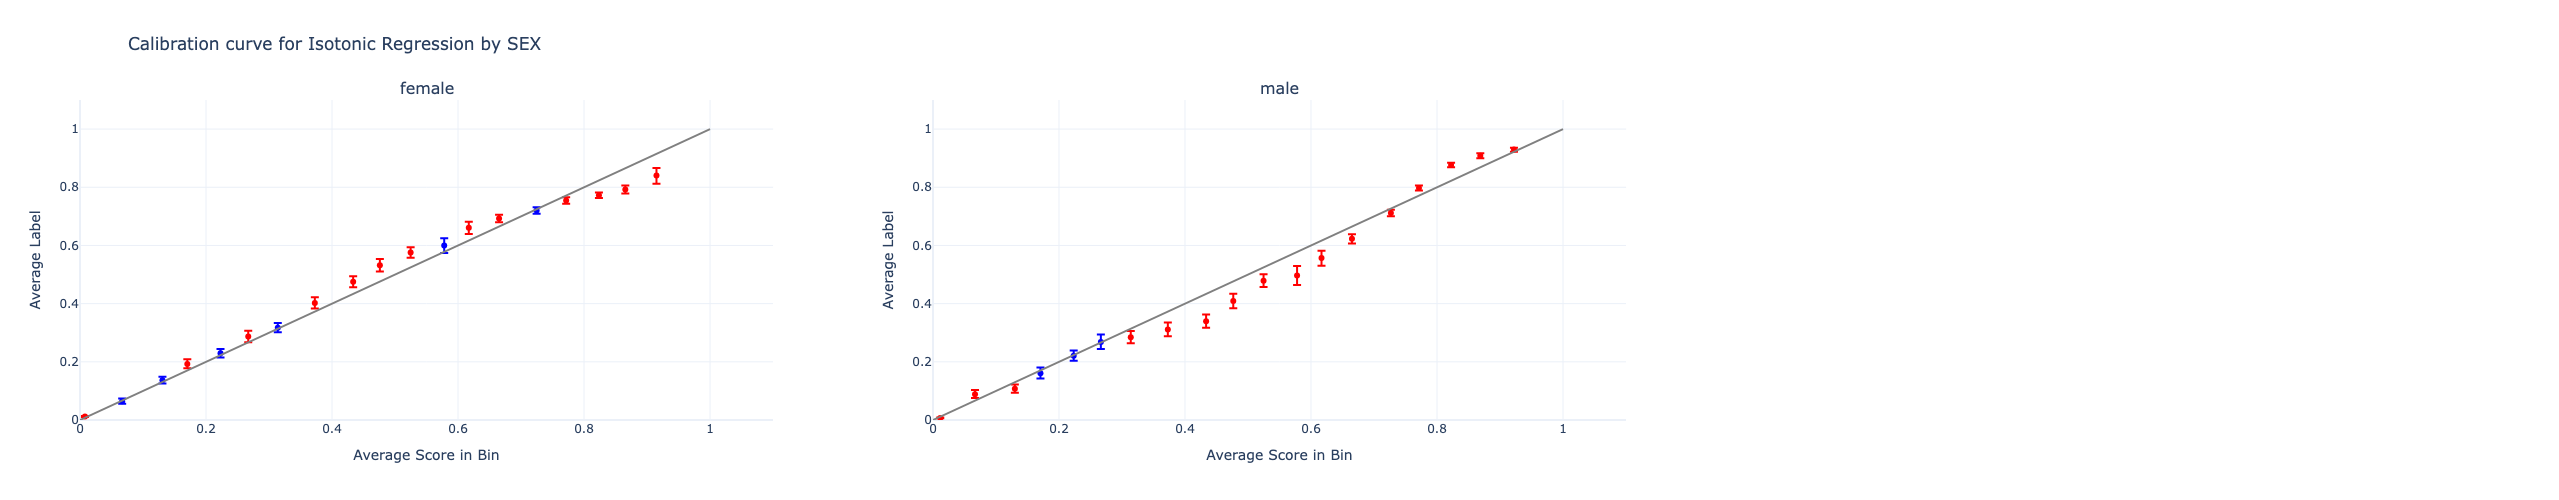

In [119]:
plot_feature = "SEX"
plotting.plot_calibration_curve_by_segment(
    # Rename codes in place
    test_df.astype({plot_feature: 'object'}).replace({plot_feature: {1: 'male', 2: 'female'}}),
    group_var=plot_feature,
    score_col=IR_SCORE_COL,
    label_col=LABEL_COLUMN,
    n_cols=3,
).update_layout(
    title=f"Calibration curve for Isotonic Regression by {plot_feature}",
    width=2000,
    height=max(10.0, 500 * (np.ceil(len(test_df[plot_feature].unique()) / 3))),
)

We can also compute the ECCE for these two segments:

In [120]:
male_test_df = test_df[test_df.SEX == 1]
female_test_df = test_df[test_df.SEX == 2]
ecce_ir_male, ecce_sigma_ir_male = compute_ecce_with_sigma(male_test_df[LABEL_COLUMN].values, male_test_df[IR_SCORE_COL].values)
ecce_ir_female, ecce_sigma_ir_female = compute_ecce_with_sigma(female_test_df[LABEL_COLUMN].values, female_test_df[IR_SCORE_COL].values)

print(f"Miscalibration of the base model after isotonic regression for **male** respondents:\nECCE: {ecce_ir_male:.4f}%, ({ecce_sigma_ir_male:.2f} sigmas)")
print(f"Miscalibration of the base model after isotonic regression for **female** respondents:\nECCE: {ecce_ir_female:.4f}%, ({ecce_sigma_ir_female:.2f} sigmas)")

Miscalibration of the base model after isotonic regression for **male** respondents:
ECCE: 0.0142%, (10.68 sigmas)
Miscalibration of the base model after isotonic regression for **female** respondents:
ECCE: 0.0124%, (9.00 sigmas)


There's still significant miscalibration when examining each sex separately. The errors are approximately symmetrical around the diagonal, canceling out at the global level.

It's impractical to manually check every possible sub-segment this way—what about females under 35? Males with disabilities in California who served in the military?

The [**Multicalibration Error (MCE)**](https://facebookincubator.github.io/MCGrad/docs/measuring-multicalibration) addresses this by computing the maximum ECCE across all segments. Let's compare the MCE for the base model and after isotonic regression:

In [130]:
mce_base_model = metrics.MulticalibrationError(
    df=test_df,
    label_column=LABEL_COLUMN,
    score_column=BASE_MODEL_PREDICTION_COLUMN,
    categorical_segment_columns=CATEGORICAL_COLUMNS + BINARY_COLUMNS,
    numerical_segment_columns=NUMERICAL_COLUMNS,
)

mce_isotonic_regression = metrics.MulticalibrationError(
    df=test_df,
    label_column=LABEL_COLUMN,
    score_column=IR_SCORE_COL,
    categorical_segment_columns=CATEGORICAL_COLUMNS + BINARY_COLUMNS,
    numerical_segment_columns=NUMERICAL_COLUMNS,
)

print(f"MCE of the base model: {mce_base_model.mce_absolute:.4f} ({mce_base_model.mce_sigma_scale:.2f} sigmas)")
print(f"MCE after isotonic regression: {mce_isotonic_regression.mce_absolute:.4f} ({mce_isotonic_regression.mce_sigma_scale:.2f} sigmas)")

MCE of the base model: 0.0355 (36.71 sigmas)
MCE after isotonic regression: 0.0360 (37.53 sigmas)


While isotonic regression almost perfectly calibrated the model at the global level. There's at least one segment with massive miscalibration. The MCE after applying isotonic regression is almost as large as for the base model, and the sigma scale tells us that this error is highly statistically significant.

To get an overview of the calibration error accross all segments considered by the MCE, we can use the plotting function `plot_segment_calibration_errors` and visualize the ECCE-sigma for all segments. Let's look at the sigma scale ECCE for the base model and isotonic regression. We will first compute the plots for each score separately using the plotting helper function `plot_segment_calibration_errors`, then combine them into a single figure with our notebook helper `combine_segment_calibration_plots`.

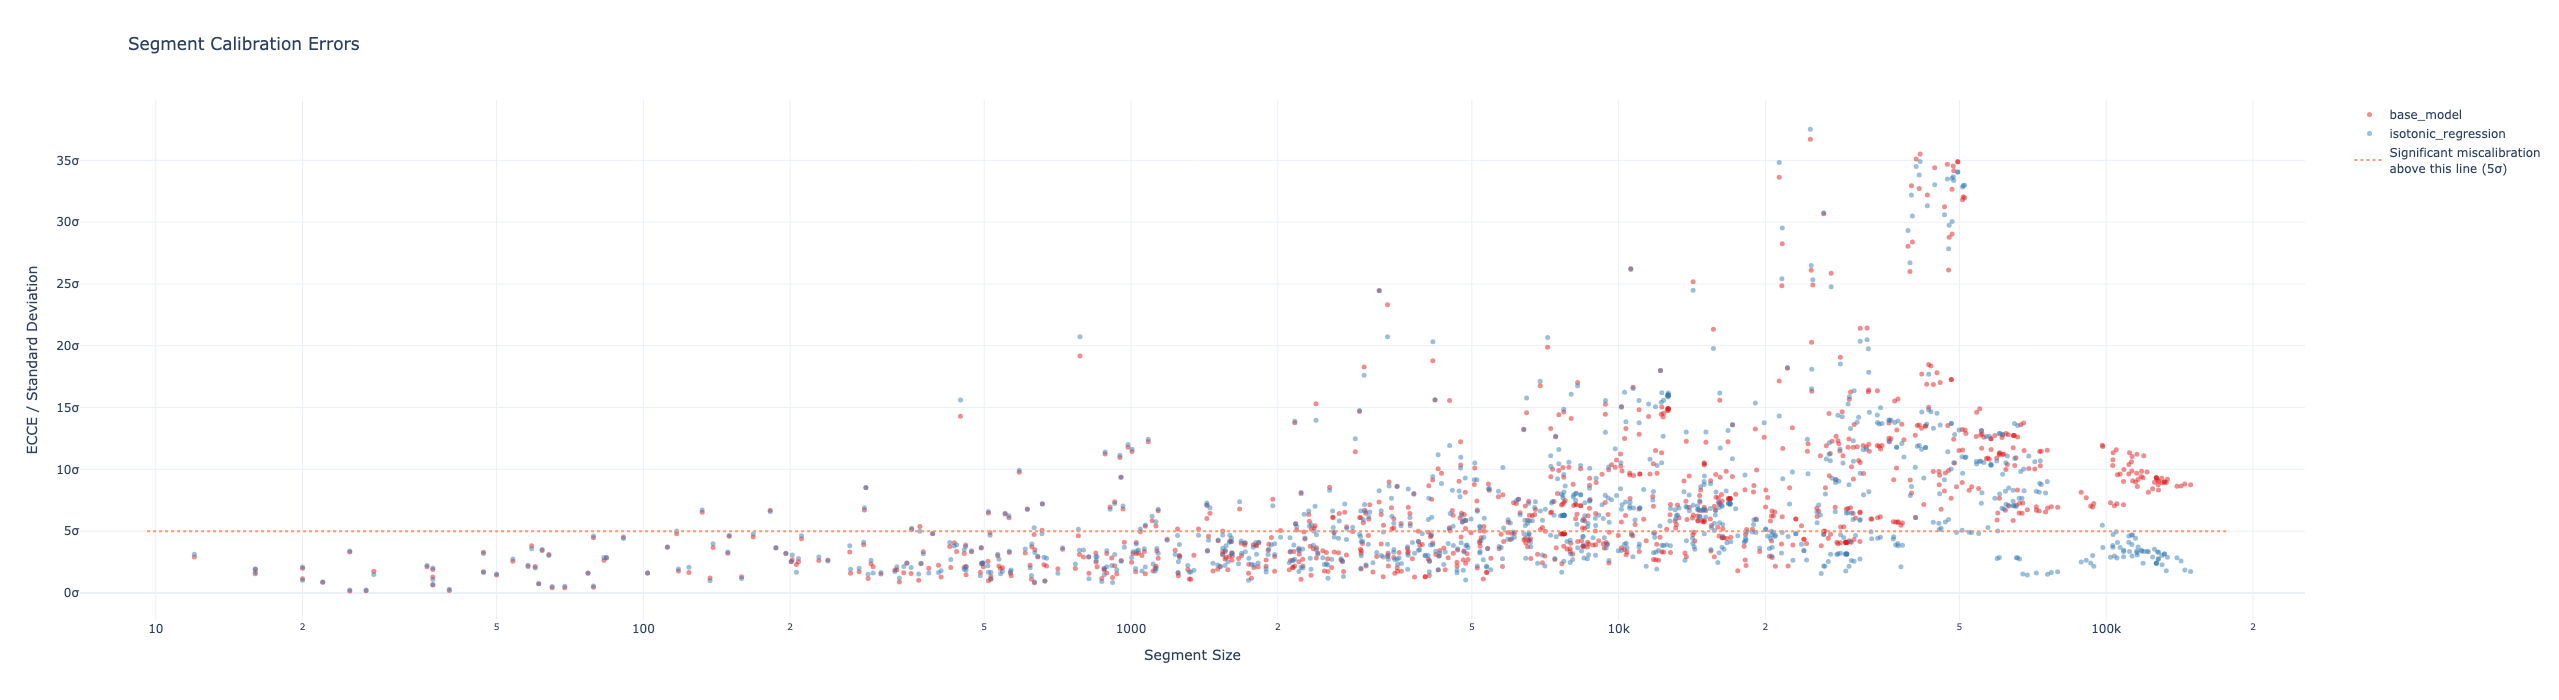

In [132]:
segment_ecce_plots = {}

segment_ecce_plots["base_model"] = plotting.plot_segment_calibration_errors(
    mce=mce_base_model, 
    quantity="segment_ecces_sigma_scale",
).update_layout(width=700)

segment_ecce_plots["isotonic_regression"] = plotting.plot_segment_calibration_errors(
    mce=mce_isotonic_regression, 
    quantity="segment_ecces_sigma_scale",
).update_layout(width=700)

combine_segment_calibration_plots(
    segment_plots=segment_ecce_plots,
    quantity="segment_ecces_sigma_scale",
).update_layout(height=700, width=1000)

Each dot in the figure represents a segment that can be formed from the available features. If you hover over a marker you see the value of each feature that defines the segment. The value `"_all_"` means that that feature is not used for this segment, i.e. all values of the feature are included.

In this case, we see that the segment with the maximum value 36.7 sigmas for  the base model and 37.53 sigmas for isotonic regression is the segment where `"SEX==1"` and `"AGEP==1"`, i.e. male respondents in the 0.33rd to 0.66th quantile of the age distribution. It's a quantile bin because "AGEP" is a numerical feature which we split into three bins based on quantiles. See the constructor argument `max_values_per_segment_feature` in the `MulticalibrationError` class.

Side note: We can also see the global calibration error by looking at the largest segment at the right end of the plot. That is, if the "global segment" has the largest miscalibration the MCE and the ECCE we computed above will be equivalent.


**Takeaway**: We have seen that even if a model is almost perfectly calibrated at the global level, there can still be significant miscalibration - and therefore room for improvement of the model calibration - in subsets of the data distribution. In the next section we will learn how to correct these mistakes.

## 3. MCGrad Basics

MCGrad is a multicalibration method based on gradient boosting. It detects and corrects miscalibration in data subsets. See the [methodology documentation](https://facebookincubator.github.io/MCGrad/docs/methodology) for algorithmic details.

MCGrad requires specifying *segment features*—the features that can potentially define segments. For example, given features `sex`, `state`, and `age`, MCGrad can correct miscalibration for segments like "females in Pennsylvania over 30" as well as all other combinations.

**Note**: Segment features are not explicit segment definitions; they're the building blocks from which segments are formed. MCGrad automatically considers all possible segments that can be constructed from the provided features.

Segment features must be declared as numerical or categorical. We use the helper arrays to assign all categorical and binary features as categorical columns and all numerical features as numerical:

In [133]:
categorical_segment_features = CATEGORICAL_COLUMNS + BINARY_COLUMNS
numerical_segment_features = NUMERICAL_COLUMNS

In [134]:
print(categorical_segment_features)

['MAR', 'RELP', 'CIT', 'MIG', 'MIL', 'ANC', 'RAC1P', 'DIS', 'ESP', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX']


In [135]:
print(numerical_segment_features)

['AGEP', 'SCHL']


MCGrad takes several configuration parameters. See the [API documentation](https://mcgrad.readthedocs.io/en/latest/api/methods.html#mcgrad.methods.MCGrad) for all constructor arguments. The default settings should usually work out of the box, here we're making a few small tweaks for this application: 

* **`save_training_performance`:** We set this to true to observe the training performance in addition to the validation performance in the early stopping cross validation process. (See the learning curve plot below)
* **`lightgbm_params`:** MGrad uses [`lightgbm`](https://lightgbm.readthedocs.io/en/stable/) under the hood. All hyperparameters that lightgbm accepts are in theory relevant to MCBoost as well. We have a specifically tuned set of default parameters, so most times you should not need to set them. Here we adjust the learning rate and number of trees in each MCGrad iteration to increase the fitting speed for this tutorial.



In [139]:
mcgrad = methods.MCGrad(
    save_training_performance=True,
    lightgbm_params={'learning_rate': 0.1, 'n_estimators': 250},
)

In [140]:
mcgrad = mcgrad.fit(
    train_df,
    BASE_MODEL_PREDICTION_COLUMN,
    LABEL_COLUMN,
    categorical_feature_column_names=categorical_segment_features,
    numerical_feature_column_names=numerical_segment_features,
)

[WARNING][2026-01-28 16:59:00][methods.py:1378]: Found 2981 (0.86%) predictions with extreme values (boundaries: [4.53979e-05, 0.999955]). These samples will be clipped in the unshrink step. Consider reviewing input prediction quality.
[INFO][2026-01-28 16:59:00][methods.py:549]: Preprocessing input data with 347609 rows; in_fit_phase = True
[INFO][2026-01-28 16:59:00][methods.py:648]: Early stopping activated, max_num_rounds=100 (timeout: 28800s)
[INFO][2026-01-28 16:59:00][methods.py:958]: Determining optimal number of rounds
[INFO][2026-01-28 16:59:00][methods.py:1282]: Found a relatively small effective sample size (347,609.0), choosing k-fold for early stopping. You can override this by explicitly setting `early_stopping_use_crossvalidation` to `False`.
[INFO][2026-01-28 16:59:00][methods.py:928]: Running early stopping using Cross Validation.
[INFO][2026-01-28 16:59:00][methods.py:948]: Using 5 folds for cross-validation.
[INFO][2026-01-28 16:59:00][methods.py:985]: Evaluating ro

MCGrad is an iterative method with integrated early stopping. We can inspect the training dynamics using `plot_learning_curve`:

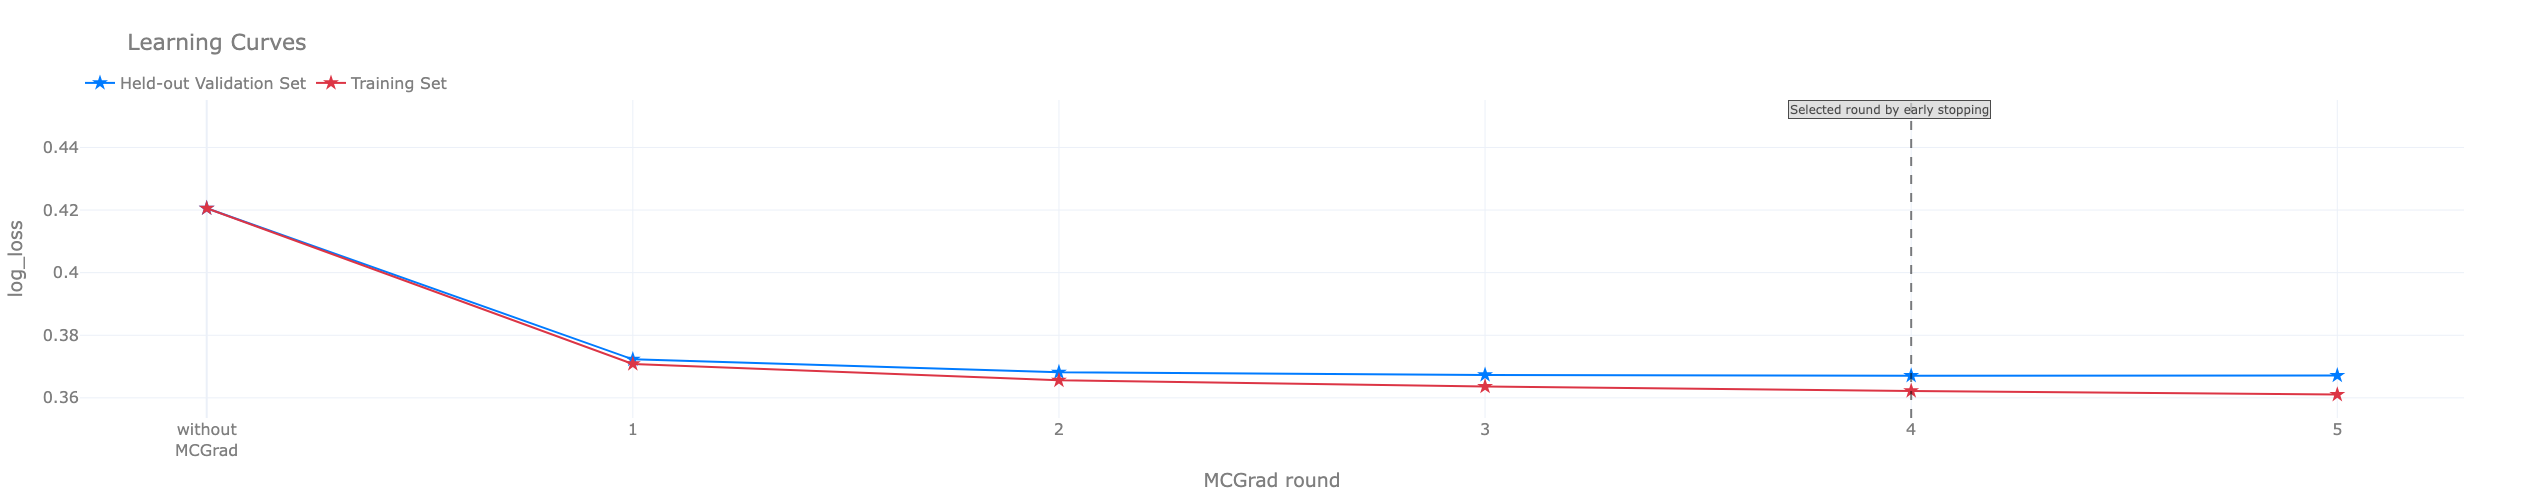

In [141]:
plotting.plot_learning_curve(mcgrad, show_all=True).update_layout(width=700, height=500)

The learning curve shows healthy training dynamics: both training and validation loss decrease monotonically until early stopping triggers when they diverge. We see significant log-loss improvement over the base model (first point in the curve).

If MCGrad cannot improve over the base model, a built-in failsafe returns a "no-op predictor" that passes through the original predictions—useful in production pipelines with automatic retraining.

## 4. Model Evaluation

Let's generate MCGrad predictions to evaluate its performance.

In [142]:
# Produce calibrated scores for all methods
MCGRAD_SCORE_COLUMN = "score_mcgrad"
test_df[MCGRAD_SCORE_COLUMN] = mcgrad.predict(
    df=test_df, 
    prediction_column_name=BASE_MODEL_PREDICTION_COLUMN, 
    categorical_feature_column_names=categorical_segment_features, 
    numerical_feature_column_names=numerical_segment_features,
)

[INFO][2026-01-28 16:59:29][methods.py:549]: Preprocessing input data with 148976 rows; in_fit_phase = False


Before looking at multicalibration over all possible segments. Let's check out the calibration in the male and female segments:

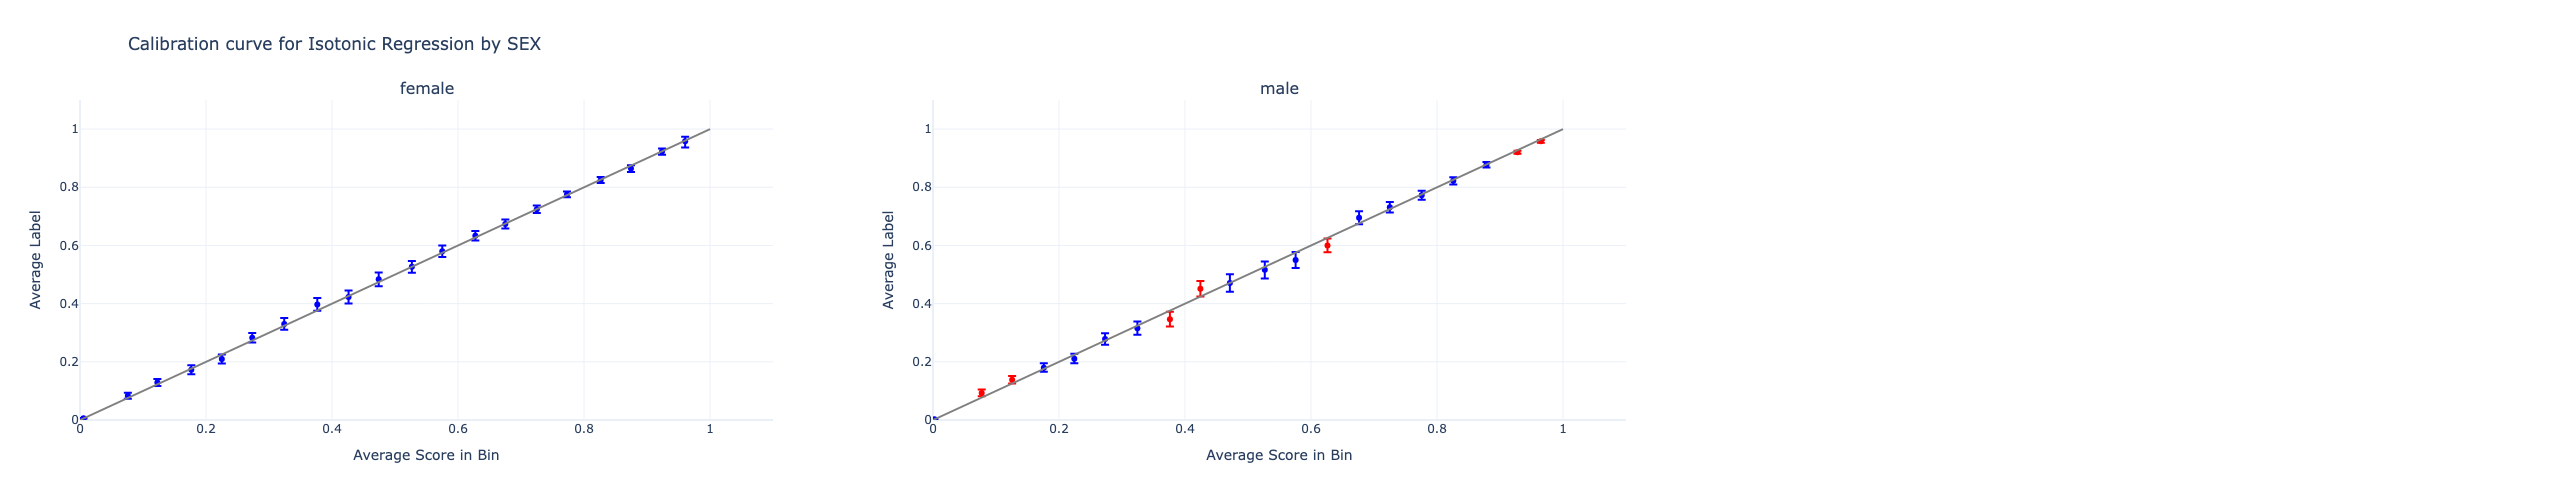

In [143]:
plot_feature = "SEX"
plotting.plot_calibration_curve_by_segment(
    # Rename codes in place
    test_df.astype({plot_feature: 'object'}).replace({plot_feature: {1: 'male', 2: 'female'}}),
    group_var=plot_feature,
    score_col=MCGRAD_SCORE_COLUMN,
    label_col=LABEL_COLUMN,
    n_cols=3,
).update_layout(
    title=f"Calibration curve for Isotonic Regression by {plot_feature}",
    width=2000,
    height=max(10.0, 500 * (np.ceil(len(test_df[plot_feature].unique()) / 3))),
)

Calibration in both segments looks much better. Let's compute the ECCE for both segments separately.

In [145]:
male_test_df = test_df[test_df.SEX == 1]
female_test_df = test_df[test_df.SEX == 2]
ecce_mcgrad_male, ecce_sigma_mcgrad_male = compute_ecce_with_sigma(male_test_df[LABEL_COLUMN].values, male_test_df[MCGRAD_SCORE_COLUMN].values)
ecce_mcgrad_female, ecce_sigma_mcgrad_female = compute_ecce_with_sigma(female_test_df[LABEL_COLUMN].values, female_test_df[MCGRAD_SCORE_COLUMN].values)

print(f"Miscalibration of the base model after isotonic regression for **male** respondents:\nECCE: {ecce_mcgrad_male:.4f}, ({ecce_sigma_mcgrad_male:.2f} sigmas)")
print(f"Miscalibration of the base model after isotonic regression for **female** respondents:\nECCE: {ecce_mcgrad_female:.4f}, ({ecce_sigma_mcgrad_female:.2f} sigmas)")

Miscalibration of the base model after isotonic regression for **male** respondents:
ECCE: 0.0032, (2.75 sigmas)
Miscalibration of the base model after isotonic regression for **female** respondents:
ECCE: 0.0022, (1.68 sigmas)


We can see that there is almost no evidence of miscalibration left. Both segments have ECCEs within 3 standard deviations of what would be expected from random variation in a perfectly calibrated model.

Now let's compare all metrics and generate plots to compare the three methods: base model, isotonic regression, and MCGrad.

First we need our final `MulticalibrationError` object for the mcgrad predictions.

In [146]:
mce_mcgrad = metrics.MulticalibrationError(
    df=test_df,
    label_column=LABEL_COLUMN,
    score_column=MCGRAD_SCORE_COLUMN,
    categorical_segment_columns=CATEGORICAL_COLUMNS + BINARY_COLUMNS,
    numerical_segment_columns=NUMERICAL_COLUMNS,
)

In [154]:
# Now that we the model scores of all calibration methods in calibrated_scores, we can do various things for evaluation, e.g. calculating some ML metrics
evaluation_metrics = {
    "PRAUC": skmetrics.average_precision_score,
    "ROCAUC": skmetrics.roc_auc_score,
    "log_loss": skmetrics.log_loss,
}

perf_metrics = {}
segment_plots = {}
global_plots = {}
calibration_metrics = {}

for score, mce_obj in zip([BASE_MODEL_PREDICTION_COLUMN, IR_SCORE_COL, MCGRAD_SCORE_COLUMN], [mce_base_model, mce_isotonic_regression, mce_mcgrad]):
    print(f"Computing metrics for {score}")
    perf_metrics[score] = {
        metric_name: metric_func(
            test_df[LABEL_COLUMN].values,
            test_df[score].values,
        )
        for metric_name, metric_func in evaluation_metrics.items()
    }
    calibration_metrics[score] = {
        # TODO: Simplify after MCE refactor lands
        "ECCE": mce_obj.global_ecce / 100 * mce_obj.prevalence,
        "ECCE " + "\u03c3": mce_obj.global_ecce_sigma_scale,
        "MCE": mce_obj.mce_absolute,
        "MCE " + "\u03c3": mce_obj.mce_sigma_scale,
    }

    fig = plotting.plot_global_calibration_curve(
        data=test_df,
        score_col=score,
        label_col=LABEL_COLUMN,
        num_bins=40,
    ).update_layout(title=f"Global Calibration Curve for {score}", width=700)
    global_plots[score] = fig
    segment_plots[score] = plotting.plot_segment_calibration_errors(
        mce=mce_obj, quantity="segment_ecces_sigma_scale"
    ).update_layout(width=700)

Computing metrics for base_model_prediction
Computing metrics for score_isotonic_regression
Computing metrics for score_mcgrad


In [155]:
pd.DataFrame(perf_metrics).T.round(3)

,PRAUC,ROCAUC,log_loss
base_model_prediction,0.824,0.880,0.421
score_isotonic_regression,0.821,0.880,0.419
score_mcgrad,0.876,0.911,0.368


MCGrad improved both discriminative performance (lower log-loss) and maintained ranking quality compared to the base model.

In [158]:
format_calibration_metrics_table(calibration_metrics).round(3)

Calibration        Multicalibration        
                                 ECCE ECCE σ              MCE   MCE σ
base_model_prediction           0.008  8.745            0.036  36.706
score_isotonic_regression       0.002  1.745            0.036  37.525
score_mcgrad                    0.002  1.645            0.004   4.704

MCGrad eliminated statistically significant multicalibration error! The MCE (maximum segment miscalibration) dropped more than eight-fold, reaching the minimum detectable threshold of ~5σ. Let's visualize the segment-wise errors:

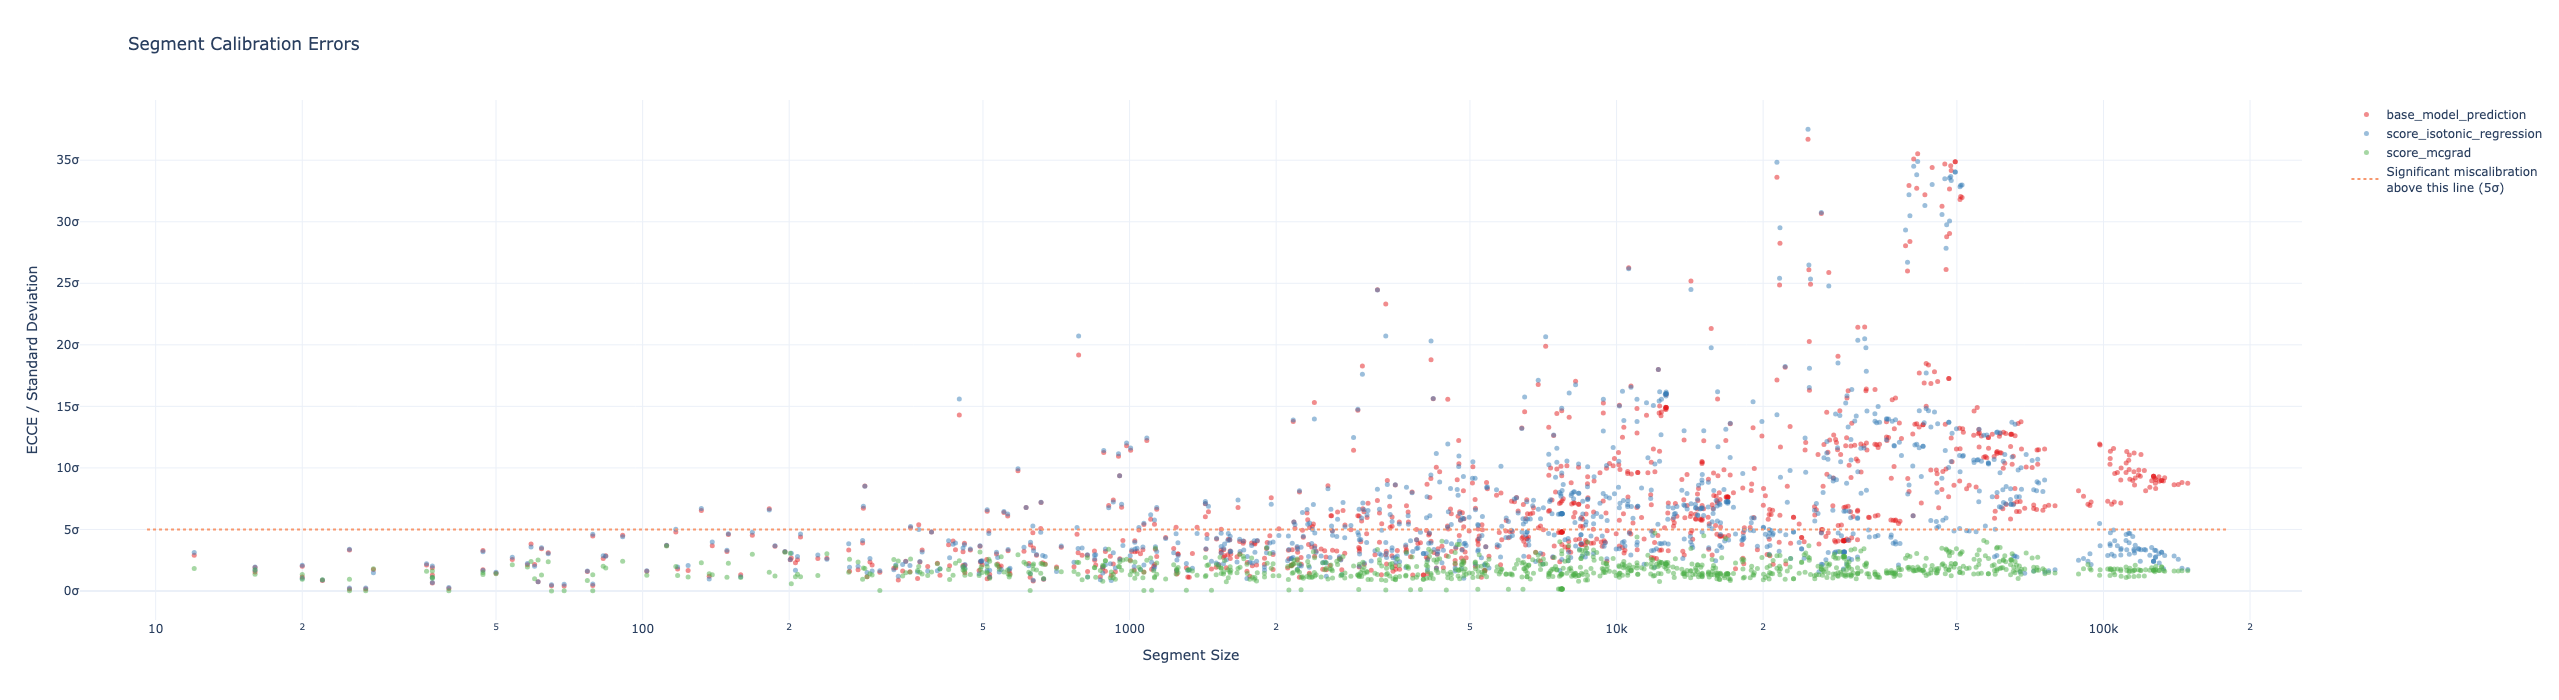

In [159]:
combine_segment_calibration_plots(
    segment_plots=segment_plots,
    quantity="segment_ecces_sigma_scale",
).update_layout(height=700, width=1000)

We see that the ECCE-sigma of all segments is pushed below 5 sigmas.

## 5. Advanced Features

TBD